In [1]:
import Bio.SeqIO
import numpy as np
import pandas as pd
from math import log
import time
import seaborn as sns
import copy
from collections import Counter
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt

## IMPORT FILES

In [2]:
filename = 'tetR_N.fasta'

In [3]:
for i, record in enumerate(Bio.SeqIO.parse(filename, "fasta")):
    print(str(i), ":", str(record.seq))

0 : VINSALELLNEVGIEGLTTRPLAQKLGVEQPTLYWHVKNKRALL


In [4]:
alignments = "msa.txt"

In [6]:
db = []
sequences = []
for i, record in enumerate(Bio.SeqIO.parse(alignments, "fasta")):  
    vec = []
    for i in str(record.seq):
        vec.append(i)
        
    sequences.append(str(record.seq))
    db.append(np.array(vec).T)

In [7]:
db = pd.DataFrame(db)

## REMOVE GAPS

In [8]:
# Remove columns which have #gaps > 50%

def removeVGaps(db):
    N = len(db)
    list_index_removal = []

    for j in range(100):
        counter_gaps = 0
        for i in range(N):
            if (db.iloc[i][j] == '.'):
                counter_gaps += 1

        if (counter_gaps > N/2):
            list_index_removal.append(j)
        
    return list_index_removal
  
def removeHGaps(db, N):
    l = []
    Nrows = len(db)
    
    transposed_db = pd.DataFrame(np.array(db).transpose())
    for j in range(Nrows):
        unique, counts = np.unique(transposed_db[j], return_counts=True)
        dict_ = dict(zip(unique, counts))

        if '-' in dict_.keys():
            if dict_['-'] > 0.50 * N:
                l.append(j)

    return l

In [9]:
start_time = time.time()
list_index_removal = removeVGaps(db)
print("--- Remove vertical gaps: %s seconds ---" % (time.time() - start_time))
filtered_db = db.drop(columns = list_index_removal)
filtered_db.columns = range(100 - len(list_index_removal))

--- Remove vertical gaps: 19.405033111572266 seconds ---


In [10]:
N = 100 - len(list_index_removal)
start_time = time.time()
l = removeHGaps(filtered_db, N)
print("--- Remove horizontal gaps: %s seconds ---" % (time.time() - start_time))

--- Remove horizontal gaps: 0.4180600643157959 seconds ---


In [11]:
print("Row indices to remove: ", l)

Row indices to remove:  []


In [12]:
filtered_db

,0,1,2,3,4,5,6,7,8,9,...,36,37,38,39,40,41,42,43,44,45
0,I,L,A,A,A,L,E,L,F,L,...,F,E,S,K,A,A,I,L,E,A
1,I,L,Q,A,A,A,E,L,F,A,...,F,R,S,K,H,E,L,L,E,A
2,L,I,T,A,A,T,A,L,F,T,...,F,A,D,K,Q,A,L,L,F,A
3,I,L,D,A,A,A,Q,L,F,A,...,F,P,S,K,D,A,I,L,V,A
4,I,I,R,S,A,Q,E,S,F,S,...,F,K,N,K,E,E,L,L,F,.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12697,L,V,E,A,A,I,D,L,F,A,...,L,G,G,K,A,G,L,R,A,A
12698,.,F,A,A,A,E,R,I,V,E,...,F,A,G,F,D,E,F,V,A,E
12699,.,.,.,.,.,R,K,H,L,A,...,V,A,S,R,D,E,L,L,.,.
12700,.,.,A,A,A,L,A,L,A,A,...,A,D,S,K,A,A,V,L,N,H


## COMPUTE ENTROPY MSA

In [11]:
# Calculate Shannon's Entropy per column of the alignment 
# (H = - sum_{i=1}^{M} P_i * log_2(P_i))

from scipy.stats import entropy
from sklearn import preprocessing
import math

amminoacids = ['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V', '-', 'X']
    
def shannon_entropy(db, M):
    
    entropy_list = []
    entropy_i = 0
    amm = np.unique(db)

    for a in amminoacids: 
        
        c = Counter(db)
        n_i = c[a]
        P_i = n_i/float(M) 
        if P_i != 0:
            entropy_i = P_i*(math.log(P_i,2))
            entropy_list.append(entropy_i)

    sh_entropy = -(sum(entropy_list))

    return sh_entropy


In [12]:
Ncol = len(filtered_db)
entropies = []
for i in range(N):
    entropy = shannon_entropy(filtered_db[i], Ncol)
    entropies.append(entropy)

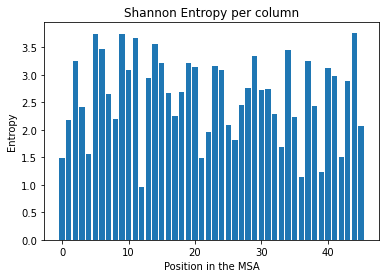

In [13]:
x = range(0, 46)
y = entropies

plt.bar(x, y)
plt.title('Shannon Entropy per column')
plt.xlabel('Position in the MSA')
plt.ylabel('Entropy')
plt.savefig('Desktop/entropy.pdf')

[61, 53, 99, 226, 7, 11, 76, 11035, 24, 1, 7, 19, 2, 1, 422, 366, 55, 2, 0, 6]


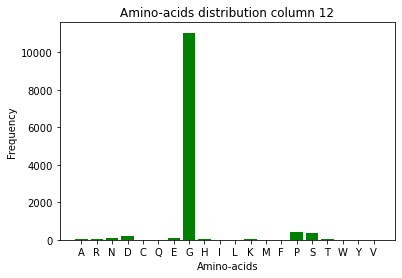

In [14]:
# Analysis of column 12 of the MSA
freq = []
amminoacids = ['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V']
for a in amminoacids: 
    c = Counter(filtered_db[12])
    freq.append(c[a])
    
print(freq)   
x = range(0, len(amminoacids))
plt.bar(amminoacids, freq, color = 'g')
plt.xlabel('Amino-acids')
plt.ylabel('Frequency')
plt.title('Amino-acids distribution column 12')
plt.savefig('Desktop/freq_distribution.pdf')

[1580, 947, 325, 871, 49, 524, 1403, 227, 236, 491, 1690, 427, 82, 300, 12, 319, 437, 11, 101, 724]


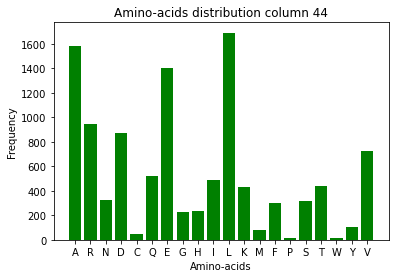

In [15]:
# Analysis of column 44 of the MSA (Highest entropy)

freq = []
amminoacids = ['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V']
for a in amminoacids: 
    c = Counter(filtered_db[44])
    freq.append(c[a])
    
print(freq)   
x = range(0, len(amminoacids))
plt.bar(amminoacids, freq, color = 'g')
plt.xlabel('Amino-acids')
plt.ylabel('Frequency')
plt.title('Amino-acids distribution column 44')
plt.savefig('Desktop/freq_distribution.pdf')

## COMPUTE MUTUAL INFORMATION

In [13]:
# Compute for each position (i,j) the Mutual Information 
Ncol = len(db)

amminoacids = ['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V']
    
def computeCount(i, a, db, Ncol):
    c = Counter(db[i])
    return c[a] / Ncol

def computeDictProbabilities(db, N, Ncol, amminoacids):
    dict_amminoacids = {}
    for i in range(N):
        for a in amminoacids:
            dict_amminoacids[(i, a)] = computeCount(i, a, db, Ncol)

    return dict_amminoacids

def computeJointCount(k, db, N, Ncol):
    
    i = k[0]
    j = k[1]
    a = k[2]
    b = k[3]
    
    x = np.array(db[i])
    y = np.array(db[j])
    
    return np.count_nonzero(np.logical_and(x == a, y == b)) / Ncol

def initializeJointDict(N, db):
    dict_joint = {}
    gap = '-'
    
    for i in range(N):
        for j in range(i):
            amm_i = list(set(db[i]) & set(amminoacids))
            amm_j = list(set(db[j]) & set(amminoacids))
            for a in amm_i:
                if a == '-':
                    pass
                for b in list(amm_j):
                    if b == '-':
                        pass
                
                    dict_joint[(i, j, a, b)] = 0  
                        
    return dict_joint
                    

def computeJointDictProbabilities(db, N, Ncol, amminoacids):
    start_time = time.time()
    dict_joint = initializeJointDict(N, db)
    print("--- Initialization of the dictionnary: %s seconds ---" % (time.time() - start_time))
    print(len(dict_joint))
    start_time = time.time()
    count = 0
    for k in dict_joint.keys():
        count += 1
        dict_joint[k] = computeJointCount(k, db, N, Ncol)
            
        if count % 100000 == 0:
            print(f"---{count} Keys: %s seconds ---" % (time.time() - start_time))
            
    return dict_joint

In [14]:
start_time = time.time()
dict_probabilities = computeDictProbabilities(filtered_db, N, Ncol, amminoacids)
print("--- Compute probability dictionnary: %s seconds ---" % (time.time() - start_time))

--- Compute probability dictionnary: 0.969749927520752 seconds ---


In [15]:
start_time = time.time()
dict_joint = computeJointDictProbabilities(filtered_db, N, Ncol, amminoacids)
print("--- Compute joint probability dictionnary: %s seconds ---" % (time.time() - start_time))

--- Initialization of the dictionnary: 2.8420050144195557 seconds ---
331783
---100000 Keys: 75.39087104797363 seconds ---
---200000 Keys: 157.35144805908203 seconds ---
---300000 Keys: 239.71704387664795 seconds ---
--- Compute joint probability dictionnary: 268.8927261829376 seconds ---


In [16]:
def computeMutualInformation(db, N, amminoacids, dict_prob, dict_joint):
    matrix = np.zeros(shape = (N, N))
    
    for i in range(N):
        for j in range(N):
            mi = 0
            for a in amminoacids:
                for b in amminoacids:
                    p_a = dict_prob[(i, a)]
                    p_b = dict_prob[(j, b)]
                    if (i, j, a, b) in dict_joint.keys():
                        p_joint = dict_joint[(i, j, a, b)]
                    elif (j, i, b, a) in dict_joint.keys():
                        p_joint = dict_joint[(j, i, b, a)]
                    else:
                        p_joint = 0

                    if (p_joint != 0):
                        mi += p_joint * log((p_joint / (p_a * p_b)), 2)

                    else:
                        mi += 0

                matrix[i][j] = mi
            
    return matrix

In [17]:
start_time = time.time()
mi = computeMutualInformation(filtered_db, N, amminoacids, dict_probabilities, dict_joint)
print("--- Compute Mutual Information matrix: %s seconds ---" % (time.time() - start_time))

for i in range(N):
    mi[i][i] = mi.max()

--- Compute Mutual Information matrix: 0.3412787914276123 seconds ---


In [18]:
mi

array([[0.40642286, 0.2244511 , 0.13447098, ..., 0.01852179, 0.03378736,
        0.05685731],
       [0.2244511 , 0.40642286, 0.18150665, ..., 0.04192643, 0.04952193,
        0.06869801],
       [0.13447098, 0.18150665, 0.40642286, ..., 0.0272659 , 0.04890954,
        0.04626602],
       ...,
       [0.01852179, 0.04192643, 0.0272659 , ..., 0.40642286, 0.15144797,
        0.09397022],
       [0.03378736, 0.04952193, 0.04890954, ..., 0.15144797, 0.40642286,
        0.20553247],
       [0.05685731, 0.06869801, 0.04626602, ..., 0.09397022, 0.20553247,
        0.40642286]])

### Implement correction to the mutual information matrix

In [32]:
# Correction MI
N = 46

def correctMI(N, mi):
    mi_corrected = np.zeros(shape = (N, N))
    
    for i in range(N):
        for j in range(N):
            if i == j:
                pass
            sum_row_col = computeSum(N, mi, i, j)
            mi_corrected[i][j] = mi[i][j] - sum_row_col / N
            
    return mi_corrected
        
        
def computeSum(N, db, i, j):
    counter = 0
    for k in range(N):
        counter += (db[k][j] + db[i][k])
    
    return counter 

In [33]:
mi_corrected = correctMI(N, mi)

MI after normalization:


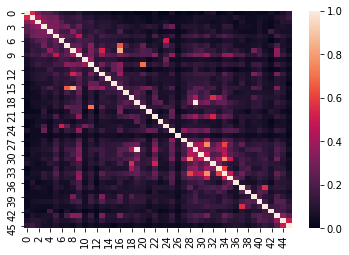

In [34]:
mimax, mimin = mi.max(), mi.min()
mi_normalized = (mi - mimin)/(mimax - mimin)
print("MI after normalization:")
hm = sns.heatmap(mi_normalized)
fig = hm.get_figure()
fig.savefig("Desktop/heatmap.pdf") 

MI corrected after normalization:


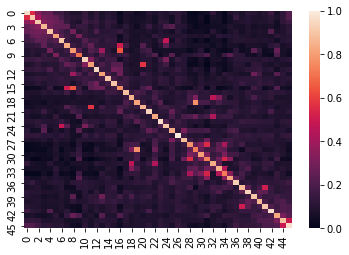

In [35]:
mimax, mimin = mi_corrected.max(), mi_corrected.min()
mi_corrected_normalized = (mi_corrected - mimin)/(mimax - mimin)
print("MI corrected after normalization:")

hm = sns.heatmap(mi_corrected_normalized)
fig = hm.get_figure()
fig.savefig("Desktop/heatmap_correction.pdf") 

## CONTACT MAP

In [36]:
# Compute the contact map from the MI matrix
# Naive approach => set the treshold to a fixed value

def computeContactMap(matrix, threshold):
    cm = np.zeros(shape = (N, N))
    
    for i in range(N):
        for j in range(N):
            if matrix[i][j] > threshold:
                cm[i][j] = 1
                
    return cm

In [37]:
start_time = time.time()
contact_map = computeContactMap(mi_corrected_normalized, 0.3)
print("--- Compute Contact Map matrix (naive treshold strategy): %s seconds ---" % (time.time() - start_time))

--- Compute Contact Map matrix (naive treshold strategy): 0.001934051513671875 seconds ---


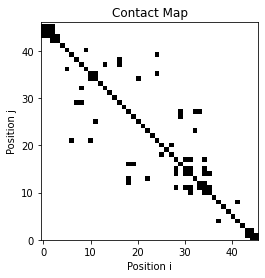

In [38]:
cm = pd.DataFrame(contact_map)
cm = cm.reindex(index=cm.index[::-1])
plt.imshow(cm, cmap='Greys')
plt.ylim(0, 46)
plt.xlabel('Position i')
plt.ylabel('Position j')
plt.title('Contact Map')
plt.savefig('Desktop/contact_map.pdf')

In [39]:
def getCorrectStructureCM(cm, N):
    arr = np.array(cm).flatten()
    return np.concatenate(([N],arr))

In [41]:
arr = getCorrectStructureCM(cm, N)

In [42]:
with open('Desktop/my_contacts_X.lst','w') as f:
    for s in arr:
        lines=f.write(str(int(s)) + '\n')

### GENERATE DIFFERENT LISTS 

In [ ]:
# Generate different contact map with different thresholds
# Generate multiple my_contacts lists to compare the 3D structure generated with the target structure
threshold = 0.1
for i in range(30):
    cm = computeContactMap(mi_corrected_normalized, threshold)
    threshold += 0.01
    arr = getCorrectStructureCM(cm, N)
    with open(f'Desktop/ML/my_contacts_{i}.lst','w') as f:
        for s in arr:
            lines=f.write(str(int(s)) + '\n')

## RESULTS

In [43]:
# Using PyMol software comparison of the predicted and target structure
# For each threshold, get the corresponding RMSD
# Plot the RMSD with respect to the threshold
# Choice of the lowest RMDS --> corresponding threshold --> best structure

In [19]:
RMSD = [(21, 14.155457971041482), (20, 13.648318291793071), (22, 10.011766420029105), (23, 9.40993033997053), (27, 11.210851198713584), (26, 14.010418452798989), (18, 11.345876425723436), (24, 8.709864516072242), (25, 10.958797375479007), (19, 7.841266600915572), (8, 4.976893919518105), (9, 8.717402330608081), (2, 7.382323589670101), (3, 7.771853445381056), (1, 6.173512630465978), (0, 8.117929933862552), (4, 5.247375864488261), (5, 10.040145070059511), (7, 8.253325776716695), (6, 7.442699379961625), (14, 5.303434834659053), (28, 13.456726117049085), (29, 6.235579013006604), (15, 8.08074546997867), (17, 8.00909874698055), (16, 8.626415313987488), (12, 7.906166009344227), (13, 9.646571786505568), (11, 8.887044608992428), (10, 8.29790706954883)]
RMSD.sort()

In [20]:
RMSD

[(0, 8.117929933862552),
 (1, 6.173512630465978),
 (2, 7.382323589670101),
 (3, 7.771853445381056),
 (4, 5.247375864488261),
 (5, 10.040145070059511),
 (6, 7.442699379961625),
 (7, 8.253325776716695),
 (8, 4.976893919518105),
 (9, 8.717402330608081),
 (10, 8.29790706954883),
 (11, 8.887044608992428),
 (12, 7.906166009344227),
 (13, 9.646571786505568),
 (14, 5.303434834659053),
 (15, 8.08074546997867),
 (16, 8.626415313987488),
 (17, 8.00909874698055),
 (18, 11.345876425723436),
 (19, 7.841266600915572),
 (20, 13.648318291793071),
 (21, 14.155457971041482),
 (22, 10.011766420029105),
 (23, 9.40993033997053),
 (24, 8.709864516072242),
 (25, 10.958797375479007),
 (26, 14.010418452798989),
 (27, 11.210851198713584),
 (28, 13.456726117049085),
 (29, 6.235579013006604)]

Min RMSD:  4.976893919518105


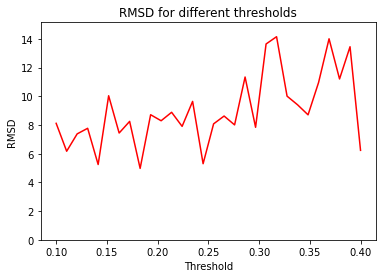

In [45]:
threshold = np.linspace(0.1, 0.4, 30)
rmsd = []
for el in RMSD:
    rmsd.append(el[1])
    
plt.plot(threshold,rmsd, 'r')
plt.ylim(0,max(rmsd)+1)
plt.title('RMSD for different thresholds')
plt.xlabel('Threshold')
plt.ylabel('RMSD')
plt.savefig('Desktop/RMSD.pdf')

print("Min RMSD: ", min(rmsd))